In [1]:
import json
import os

import chromadb
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from chromadb.utils import embedding_functions
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [2]:
# https://docs.trychroma.com/guides
CHROMA_DATA_PATH = "chroma_data/"
EMBED_MODEL = "all-MiniLM-L6-v2"
# EMBED_MODEL = "all-mpnet-base-v2"
COLLECTION_NAME = "arxiv_papers"
BATCH_SIZE = 5000

CHROMA_DATA_PATH = os.path.join(CHROMA_DATA_PATH, EMBED_MODEL)

In [3]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

parquet_path = '../data/arxiv_metadata_sample.parquet.gzip'
arxiv_df = pd.read_parquet(parquet_path)

print(arxiv_df.shape)

(119503, 14)


In [4]:
def text_processing(sample):
    title = sample['title']
    abstract = sample['abstract']

    # remove special characters
    title = title.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    abstract = abstract.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # remove multiple spaces
    title = ' '.join(title.split())
    abstract = ' '.join(abstract.split())

    return f"Title: {title} - Abstract: {abstract}"

In [5]:
arxiv_df['text'] = arxiv_df.apply(text_processing, axis=1)
arxiv_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,amount_super_categories,super_categories_str,super_category,text
0,2306.01499,Can LLMs like GPT-4 outperform traditional AI ...,Recent investigations show that large langua...,"[cs.CL, cs.LG]",2023-06-05,15,163,"[Computation and Language, Machine Learning]",2,2023,"[Artificial Intelligence, Artificial Intellige...",2,Computer Science and Artificial Intelligence,Artificial Intelligence,Title: Can LLMs like GPT-4 outperform traditio...
1,2312.05019,Vision-based Learning for Drones: A Survey,Drones as advanced cyber-physical systems ar...,"[cs.RO, cs.AI]",2024-01-03,6,181,"[Robotics, Artificial Intelligence]",2,2024,"[Artificial Intelligence, Artificial Intellige...",2,Computer Science and Artificial Intelligence,Artificial Intelligence,Title: Vision-based Learning for Drones: A Sur...
2,2307.14359,A new derivative-free optimization method: Gau...,Optimization methods are essential in solvin...,"[math.OC, cs.LG]",2023-07-28,8,114,"[Optimization and Control, Machine Learning]",2,2023,"[Engineering and Technology, Artificial Intell...",2,Computer Science and Artificial Intelligence E...,Artificial Intelligence,Title: A new derivative-free optimization meth...


In [6]:
def create_metadatas(arxiv_df):
    metadatas = []
    for _, row in arxiv_df.iterrows():
        metadatas.append({
            "update_date": row['update_date'],
            "title_words": row['title_words'],
            "abstract_words": row['abstract_words'],
            "super_category": row['super_category'],
            "mapped_categories": ";".join(row['mapped_categories']),
        })

    return metadatas

In [7]:
def create_collection(client, collection_name, embedding_function):
    collection = client.create_collection(
        name=collection_name,
        embedding_function=embedding_function,
        metadata={"hnsw:space": "cosine"},
        get_or_create=True,
    )

    return collection

def delete_collection_data(client, collection, collection_name):
    print(f"Deleting data from collection {collection_name} with {collection.count()} documents")
    client.delete_collection(collection_name)

def get_random_samples_from_collection(collection, n_samples):
    collection_ids = collection.get()["ids"]
    random_ids = np.random.choice(collection_ids, n_samples, replace=False).tolist()
    documents = collection.get(ids=random_ids)
    return documents

def upsert_data(collection, arxiv_df, metadatas, batch_size):
    for i in tqdm(range(0, len(arxiv_df), batch_size)):
        collection.upsert(
            documents=arxiv_df['text'].iloc[i:i + batch_size].tolist(),
            ids=arxiv_df['id'].iloc[i:i + batch_size].tolist(),
            metadatas=metadatas[i:i + batch_size],
        )

In [8]:
# delete the collection if it exists
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=EMBED_MODEL,
    device="cuda",
)

collection = create_collection(client, COLLECTION_NAME, embedding_func)

# delete if you want to start fresh but then you need to create the collection again
# delete_collection_data(client, collection, COLLECTION_NAME)
# collection = create_collection(client, COLLECTION_NAME, embedding_func)

# create metadatas
# metadatas = create_metadatas(arxiv_df)

# upsert data (insert or update if exists)
# upsert_data(collection, arxiv_df, metadatas, BATCH_SIZE)

w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# Define query
words_per_line = 10
# define papers to show
top_n_papers = 3
query = "Deep Learning and veganism"
print("Query:\n", query, "\n")
query_results = collection.query(query_texts=[query], n_results=top_n_papers)
for _id, _doc, _dist, _meta in zip(query_results["ids"][0], query_results["documents"][0], query_results["distances"][0], query_results["metadatas"][0]):
    print(f"#####   ID: {_id}   #####")
    print(f"Distance: {_dist}")
    print(f"Metadata: {_meta}")
    _doc_lines = _doc.split()
    for i in range(0, len(_doc_lines), words_per_line):
        print(" ".join(_doc_lines[i:i + words_per_line]))
    print("\n")

Query:
 Deep Learning and veganism 

#####   ID: 2204.05095   #####
Distance: 0.4834827184677124
Metadata: {'abstract_words': 193, 'mapped_categories': 'Data Analysis, Statistics and Probability', 'super_category': 'Data Science and Information Theory', 'title_words': 5, 'update_date': '2022-04-12'}
Title: Physics is the New Data - Abstract: The rapid
development of machine learning (ML) methods has fundamentally affected numerous
applications ranging from computer vision, biology, and medicine to accounting
and text analytics. Until now, it was the availability of
large and often labeled data sets that enabled significant breakthroughs.
However, the adoption of these methods in classical physical disciplines
has been relatively slow, a tendency that can be traced
to the intrinsic differences between correlative approaches of purely data-based
ML and the causal hypothesis-driven nature of physical sciences. Furthermore,
anomalous behaviors of classical ML necessitate addressing issues 

In [10]:
response = collection.get(include=["metadatas", "documents", "embeddings"])
df = pd.DataFrame({
    "id": response["ids"],
    "document": response["documents"],
    "embedding": response["embeddings"],
    "super_category": [x["super_category"] for x in response["metadatas"]],
})
# all_categories = df["categories"].explode().unique()
all_categories = df["super_category"].unique()
cat_mapping = {cat: i for i, cat in enumerate(all_categories)}
df["cat_id"] = df["super_category"].apply(lambda x: cat_mapping[x])
# df.loc[:, all_categories] = df["super_category"].apply(lambda x: [1 if cat in x else 0 for cat in all_categories]).tolist()
df.head(3)

,id,document,embedding,super_category,cat_id
0,1001.0039,"Title: TGCat, The Chandra Transmission Grating...","[-0.10545571893453598, 0.01092915702611208, -0...",Astrophysics and Cosmology,0
1,1001.0051,Title: Lukewarm dark matter: Bose condensation...,"[-0.08181954175233841, -0.020921852439641953, ...",Astrophysics and Cosmology,0
2,1001.0057,Title: Arrested phase separation in reproducin...,"[-0.10529515147209167, -0.07971720397472382, -...",Biological Sciences and Medicine,1


In [11]:
from renumics import spotlight

spotlight.show(df)

Exception in thread Thread-9 (_handle_connections):
Traceback (most recent call last):
  File "W:\Python\py311\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "W:\Python\py311\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\renumics\spotlight\server.py", line 342, in _handle_connections
    msg = self.connection.recv()
          ^^^^^^^^^^^^^^^^^^^^^^
  File "W:\Python\py311\Lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
          ^^^^^^^^^^^^^^^^^^
  File "W:\Python\py311\Lib\multiprocessing\connection.py", line 430, in _recv_bytes
    buf = self._recv(4)
          ^^^^^^^^^^^^^
  File "W:\Python\py311\Lib\multiprocessing\connection

# Simple Classification Head

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class EmbeddingDataset(Dataset):
    def __init__(self, df, cat_ids):
        self.ids = df["id"].values
        self.embeddings = torch.tensor(df["embedding"].tolist(), dtype=torch.float32)
        self.categories = torch.tensor(df["cat_id"].values, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.embeddings[idx], self.categories[idx]

class EmbeddingModel(torch.nn.Module):
    def __init__(self, n_emb_size, n_categories):
        super(EmbeddingModel, self).__init__()
        self.fc1 = torch.nn.Linear(n_emb_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, n_categories)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# train val split
emb_dataset = EmbeddingDataset(df, cat_mapping)
train_size = int(0.8 * len(emb_dataset))
val_size = len(emb_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(emb_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingModel(len(df["embedding"].values[0]), len(all_categories)).to(device)

Train size: 95602
Val size: 23901


In [18]:
def train(model, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for _, emb, cat in train_loader:
            emb, cat = emb.to(device), cat.to(device)
            optimizer.zero_grad()
            output = model(emb)
            loss = criterion(output, cat)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for _, emb, cat in val_loader:
                emb, cat = emb.to(device), cat.to(device)
                output = model(emb)
                _, predicted = torch.max(output.data, 1)
                total += cat.size(0)
                correct += (predicted == cat).sum().item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {100 * correct / total}")

train(model, train_loader, val_loader, epochs=10)

Epoch 1/10, Loss: 0.7556178569793701, Accuracy: 75.83364712773525
Epoch 2/10, Loss: 0.42003190517425537, Accuracy: 76.75829463202376
Epoch 3/10, Loss: 0.38508155941963196, Accuracy: 77.54068867411405
Epoch 4/10, Loss: 0.8198814988136292, Accuracy: 77.73314924061755
Epoch 5/10, Loss: 0.780788004398346, Accuracy: 77.75825279277018
Epoch 6/10, Loss: 0.8643059134483337, Accuracy: 78.2268524329526
Epoch 7/10, Loss: 0.5760236978530884, Accuracy: 78.4611522530438
Epoch 8/10, Loss: 0.41133925318717957, Accuracy: 78.4611522530438
Epoch 9/10, Loss: 0.18678654730319977, Accuracy: 78.75402702815782
Epoch 10/10, Loss: 0.4386148750782013, Accuracy: 78.83352160997448


# cluster

In [33]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

num_classes = len(cat_mapping)
print(f"Number of classes: {num_classes}")
# arxiv_df['class'] = arxiv_df['super_category'].apply(lambda x: cat_mapping[x])
df['class'] = df['super_category'].apply(lambda x: cat_mapping[x])
p_per_class = .1
# only use p_per_class percent of each class
sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class)).reset_index(drop=True)
print(f"Sampled data shape: {sampled_df.shape}")

Number of classes: 12
Sampled data shape: (11950, 8)


C:\Users\gabri\AppData\Local\Temp\ipykernel_56980\2616776934.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



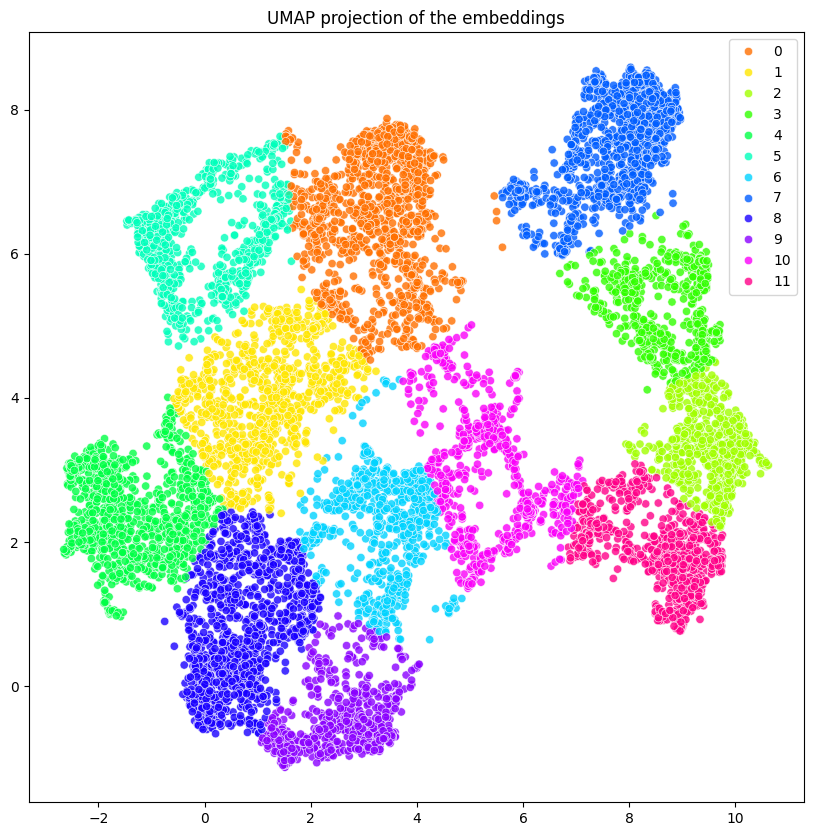

In [34]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalizing the data
embedding_data = np.array(sampled_df["embedding"].tolist())
scaler = StandardScaler()
embedding_data_scaled = scaler.fit_transform(embedding_data)

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(embedding_data_scaled)

# K-Means Clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

# visualize
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=kmeans_labels,
    palette=sns.color_palette("hsv", num_classes),
    legend="full",
    alpha=0.8,
)

plt.title("UMAP projection of the embeddings")
plt.show()

In [38]:
import plotly.express as px

# Create a dataframe for plotly
plot_df = pd.DataFrame(umap_embeddings, columns=['UMAP 1', 'UMAP 2'])
plot_df['Cluster'] = kmeans_labels
plot_df['Class'] = df['cat_id']

# Define markers for actual classes
markers = ['circle', 'square', 'triangle-up', 'diamond', 'triangle-down', 'triangle-left', 'triangle-right', 'pentagon', 'star', 'hexagon']

# Create a new column for marker shapes
plot_df['Marker'] = plot_df['Class'].apply(lambda x: markers[x % len(markers)])

# Plot using plotly
fig = px.scatter(plot_df, x='UMAP 1', y='UMAP 2', color='Cluster', symbol='Marker',
                 title="UMAP embeddings colored by KMeans labels and shaped by actual classes",
                 symbol_map={str(i): marker for i, marker in enumerate(markers)}, width=1800, height=800)

fig.update_traces(marker=dict(size=5))  # Adjust the marker size
fig.show()

In [41]:
# calculate accuracy
def calculate_accuracy(df, kmeans_labels, cat_mapping):
    df["kmeans_labels"] = kmeans_labels
    correct = 0
    total = 0
    for cat, kmeans_label in zip(df["cat_id"], df["kmeans_labels"]):
        if cat == kmeans_label:
            correct += 1
        total += 1

    return correct / total

accuracy = calculate_accuracy(sampled_df, kmeans_labels, cat_mapping)
print(f"Accuracy: {accuracy}")

Accuracy: 0.04175732217573222
